# Initial Data Exploration

Aight, let's have a look at the data we are working with!

This notebook will mostly be about exploring the data, maybe discovering some connections (or not).

Maybe I will even use the dataset in a first, very clumsy model. Let's see.

This is all just early stages, I will probably backpedal a bit in the next notebook and continue a bit more organized.
But for now, some fun with data:

## loading data

The file I am loading from is just a json dump from the API that recorded the measurements from the sensor.

In [2]:
import pandas as pd
with open("../data/measurements.json") as file:
    data = pd.read_json(file)

In [3]:
data.head()

,humidity,measuredAt,temperature
0,34.2,2018-02-20T19:00:08.145411Z,17.1
1,33.3,2018-02-20T18:00:09.190775Z,16.8
2,32.5,2018-02-20T17:00:10.197395Z,17.9
3,34.8,2018-02-20T16:00:08.208562Z,17.7
4,35.9,2018-02-20T15:00:08.232641Z,17.9


## Some initial insights

Aight, so the datapoints are recorded every hour.

The info() method is especially useful to get a feel for the shape of the data. There are 6138 instances in the dataset, which is fairly small, but a doable start.

The number of non-null values for each column is very interesting - I got lucky, there are no values missing in any columns, otherwise I would've needed to take care of that (the number of non-null values for each column is the same as the number of instances in the dataset).

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6138 entries, 0 to 6137
Data columns (total 3 columns):
humidity       6138 non-null float64
measuredAt     6138 non-null object
temperature    6138 non-null float64
dtypes: float64(2), object(1)
memory usage: 191.8+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1160041d0>,
      dtype=object)

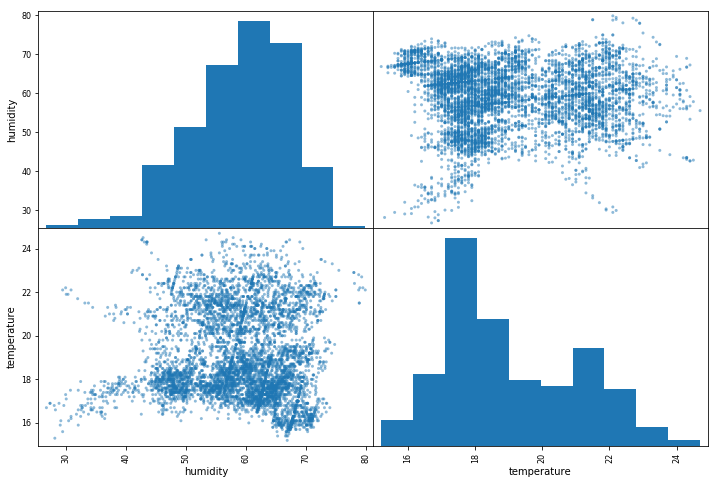

In [7]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, figsize=(12, 8))

The correlation coefficients range from -1 to 1. When there is a strong positive correlation (close to 1) it means that a value tends to go up when the other one goes up.

When there is a strong negative correlation (close to -1) it means that a value tends to go down when the correlated value goes down.

It seems there is a slight negative correlation between temperature and humidity (when one of them goes down, the other tends to go down a bit too).

This will become much more interesting once we add some more features.

In [8]:
data.corr()

,humidity,temperature
humidity,1.000000,-0.020763
temperature,-0.020763,1.000000


I will add a few features, hour and month, by extracting them from the timestamp. The strongest correlation we can find is between month and humidity. The later in the year we are, the higher the humidity tends to go up. Hmm...

In [9]:
data['hour'] = pd.DatetimeIndex(data['measuredAt']).hour
data['month'] = pd.DatetimeIndex(data['measuredAt']).month
data.corr()

,humidity,temperature,hour,month
humidity,1.000000,-0.020763,-0.030269,0.597713
temperature,-0.020763,1.000000,0.077384,-0.140751
hour,-0.030269,0.077384,1.000000,0.000898
month,0.597713,-0.140751,0.000898,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116171f28>,
      dtype=object)

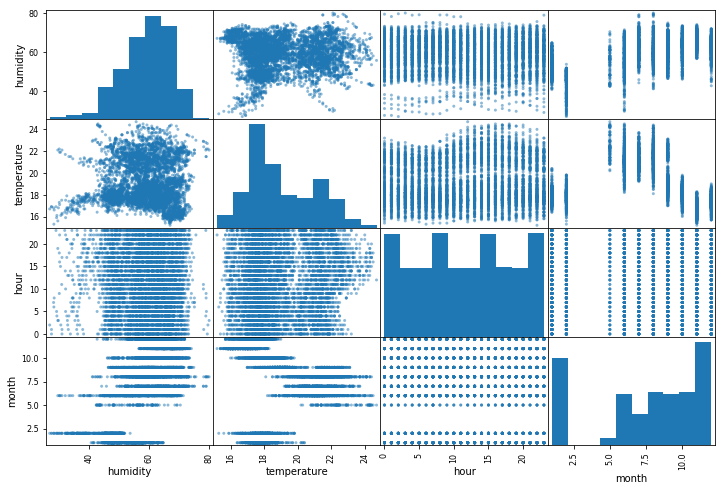

In [10]:
scatter_matrix(data, figsize=(12, 8))

Ok, plotting time! This is probably the most valuable overview we can get initially.

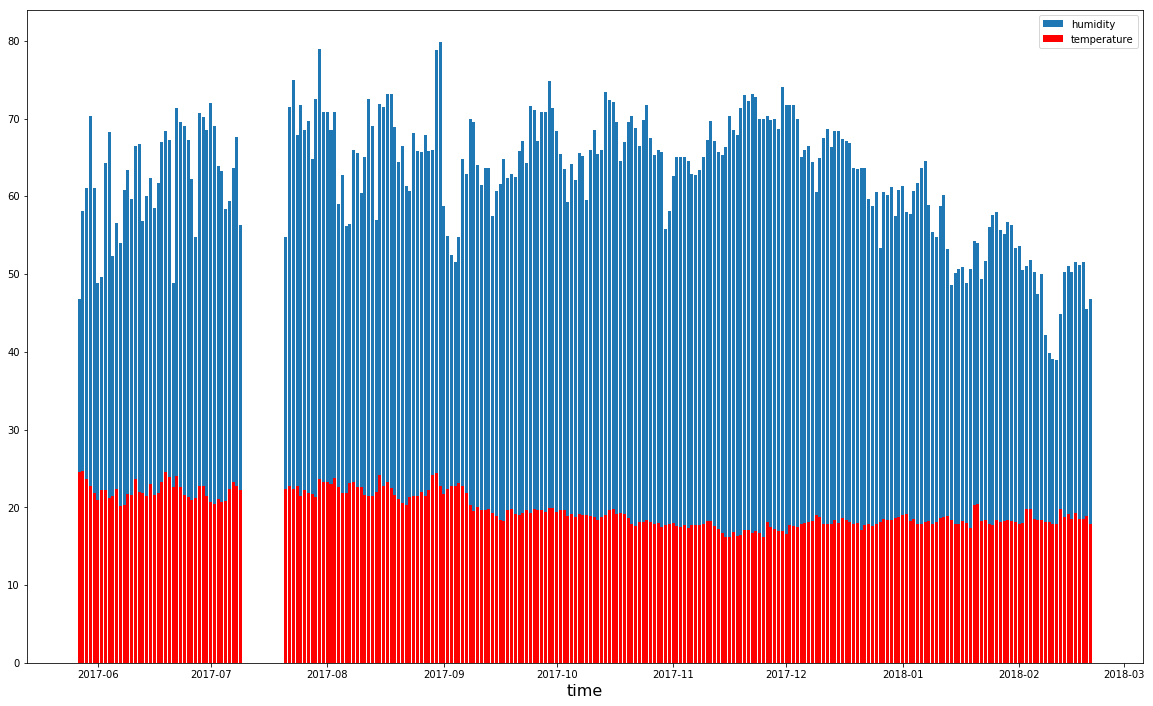

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

# creating timestamps for the x axis
dates = [dt.datetime.strptime(d, '%Y-%m-%dT%H:%M:%S.%fZ').date() for d in data.measuredAt]
plt.figure(figsize=(20,12))
plt.xlabel("time", fontsize=16)
plt.bar(dates, data.humidity, label="humidity")

# humidity and temperature are obviously not on the same scale here
plt.bar(dates, data.temperature, color="red", label="temperature")
plt.legend()
plt.show()

Oh right, the sensor was disconnected for a bit last year - the missing data in the time series is something I need to deal with later.

![suspicious drop](img/data_drop.png)

important side note: If you value peace and harmony at home, you should not gleefully start singing to your girlfriend:

"I found the cause, it is you, it is YOU! the data doesn't lie, it doesn't lie, doesn't lie".

Especially if she has a PhD in this stuff and can easily show you the folly of your premature assumptions.

The major folly in this case being: I tried to see too detailed patterns in the data already. 

Your brain(my brain too I would hope) is a fantastic pattern detector and very prone to _overfitting_.

Which means that whatever solution we would create, it might work great for the data we are looking at, but would likely be very bad at generalizing. There is more to the story and I will return to it at a later point, when we measure the performance of the algorithm.

To avoid overfitting and to properly measure the performance we will split the dataset into a training set and a test set. The training set will be used to train the regressor and the test set will be used to evaluate the performance. Do not snoop into the test set! Otherwise you might accidentally start overfitting on the test set too.

## A first, clumsy model

### make usable features (feature extension?)

We need to change the date to some number that a linear regression model can actually use.
Before we go into some of the more involved methods like 1-of-K encoding, we are going to try to extract some numbers from the date.

#### extract hour and month

In [56]:
data['hour'] = pd.DatetimeIndex(data['measuredAt']).hour
data['month'] = pd.DatetimeIndex(data['measuredAt']).month

### create a test set

In [57]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

### split into features and label

In [58]:
feature_attributes = ['temperature', 'hour', 'month']
label_attributes = ['humidity']
X_train, y_train = train_set[feature_attributes], train_set[label_attributes]
X_test, y_test = test_set[feature_attributes], test_set[label_attributes]

### explore the data

In [59]:
X_train.describe()

,temperature,hour,month
count,4868.000000,4868.000000,4868.000000
mean,19.061278,11.436113,7.591619
std,1.992440,6.916110,3.528455
min,15.300000,0.000000,1.000000
25%,17.500000,5.000000,6.000000
50%,18.500000,11.000000,8.000000
75%,20.800000,17.000000,10.000000
max,24.700000,23.000000,12.000000


In [60]:
y_train.describe()

,humidity
count,4868.000000
mean,59.200719
std,7.990196
min,27.400000
25%,54.200000
50%,60.200000
75%,65.200000
max,79.900000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1113e60f0>,
      dtype=object)

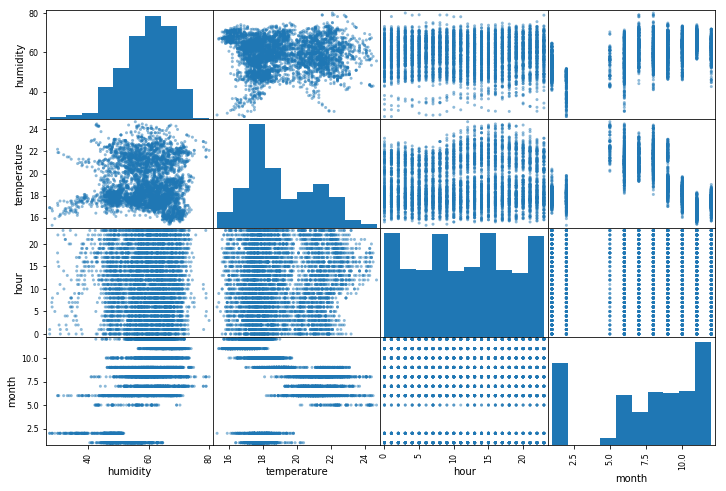

In [62]:
from pandas.plotting import scatter_matrix
scatter_matrix(train_set, figsize=(12, 8))

In [73]:
print(train_set.corr())

             humidity  temperature      hour     month
humidity     1.000000    -0.035809 -0.017623  0.583844
temperature -0.035809     1.000000  0.083101 -0.155750
hour        -0.017623     0.083101  1.000000  0.008984
month        0.583844    -0.155750  0.008984  1.000000


In [72]:
X_train.shape

(4868, 3)

In [64]:
y_train.shape

(4868, 1)

## train model

### linear regression

In [65]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

/Users/oem/.pyenv/versions/3.6.3/envs/habitat/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [66]:
from sklearn.metrics import mean_squared_error
predictions = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


6.419687849740649

In [67]:
d = {'temperature': [17.5, 18], 'hour': [19, 20], 'month': [1,1]}
df = pd.DataFrame(data=d)
df

,hour,month,temperature
0,19,1,17.5
1,20,1,18.0


In [68]:
lin_reg.predict(df)

array([[72.83351493],
       [73.74147805]])

### plot the predictions vs measured values

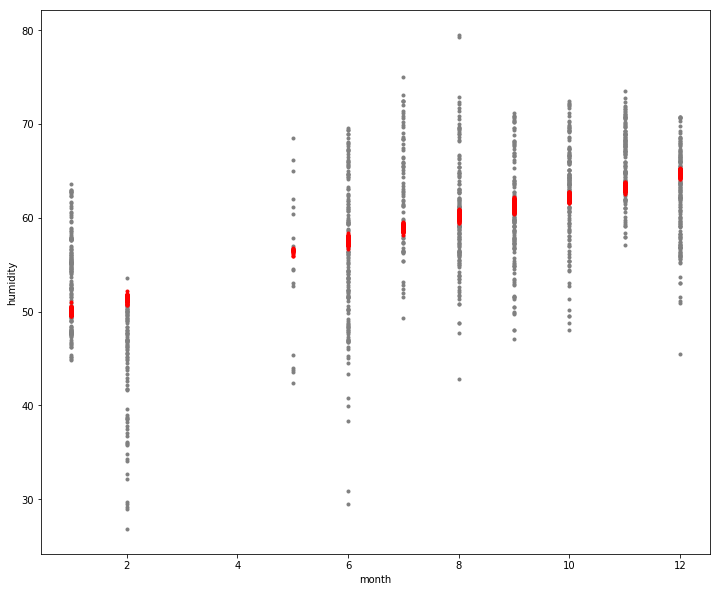

In [69]:
plt.figure(figsize=(12,10))
plt.plot(X_test['month'], y_test, '.', color='gray')
plt.plot(X_test['month'], predictions, '.', color='r')
plt.xlabel('month')
plt.ylabel('humidity')
plt.show()